In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, accuracy_score
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from transformers import AutoTokenizer, AutoModel
import torch

from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

import pandas as pd
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
import torch

from sklearn.model_selection import train_test_split
import torch

from transformers import TrainingArguments, Trainer

import evaluate

from sklearn.utils.class_weight import compute_class_weight

from torch import nn
from transformers import Trainer
import optuna

from sklearn.model_selection import StratifiedKFold

import json

/home/losullivan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-06 10:55:25.836553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:55:25.836600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:55:25.836634: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:55:25.844391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

In [2]:

# antibiotics dataset - labelled
antibiotics_df = pd.read_excel('Dataset_antibiotic_superbug.xlsx', skiprows=4, sheet_name='Training data') 
antibiotics_df

,SMILES,Name,Rep 1,Rep 2,Mean,Label,Total positives,Total negatives
0,C=CC(C1=CC(=O)C(OC)=CC1=O)c1ccc(O)cc1,4-METHOXY-4'-HYDROXY-DALBERGIONE,1.041500,1.124500,1.083000,0,112.0,7573.0
1,C=C1CC/C=C(/C)CC[C@@H]2[C@@H]1CC2(C)C.O,(-)E-CARYOPHYLLENE hydrate,0.846050,1.028200,0.937125,0,NaN,NaN
2,CCCCCCCCCCCCCCCC(=O)OCC(O)CO,1-MONOPALMITIN,1.089400,1.247000,1.168200,0,NaN,NaN
3,CC1(C)C(=O)[C@@H]2O[C@@H]2[C@@]2(C)C1C[C@@H](O...,"1,2alpha-EPOXYDEACETOXYDIHYDROGEDUNIN",1.168100,1.171700,1.169900,0,NaN,NaN
4,CC1(C)C2CC(=O)[C@]3(C)C(CC[C@@]4(C)[C@H](c5cco...,"1,3-DIDEACETYL-7-DEACETOXY-7-OXOKHIVORIN",1.195300,1.228100,1.211700,0,NaN,NaN
...,...,...,...,...,...,...,...,...
7679,C=CCN1C(C)=N[C@H]2C=C[C@H](NCCCO)[C@H]21,BRD-M85061937,0.987031,1.071989,1.029510,0,NaN,NaN
7680,CI.O=C(COc1ccc(Cl)cc1Cl)OC[C@H]1CCCN2CCCC[C@@H]12,BRD-M95218988,1.043885,0.848576,0.946230,0,NaN,NaN
7681,O=C(O)C(Cl)Cl.[NaH],BRD-M97302542,0.998363,1.137398,1.067881,0,NaN,NaN
7682,N#Cc1cc(F)cc(Oc2ccc(S(=O)(=O)C(F)F)c3c2CC(F)(F...,BRD-M99730827,0.997820,1.269089,1.133454,0,NaN,NaN


In [3]:
# antibiotics dataset - test set
test_df = pd.read_excel('Dataset_antibiotic_superbug.xlsx', skiprows=2, sheet_name='Screening predictions')
test_df

,SMILES,Sample,Predicted probability,Activity_model_0,Activity_model_1,Activity_model_2,Activity_model_3,Activity_model_4,Activity_model_5,Activity_model_6,Activity_model_7,Activity_model_8,Activity_model_9,SMILES_nearest_neighbor,SMILES_nearest_neighbor_similarity
0,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(F)c2c(c1F)n(cc(...,BRD-K63001556-001-11-9,0.957252,9.979860e-01,0.963472,9.879874e-01,0.962334,9.855424e-01,0.919328,0.908608,0.989274,0.898570,0.959418,C[C@H]1CN(c2c(F)c(F)c3c(=O)c(C(=O)O)cn(C4CC4)c...,1.000000
1,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(N)c2c(c1F)n(cc(...,BRD-K07612980-001-08-9,0.950735,9.951907e-01,0.963207,9.917750e-01,0.955759,9.787208e-01,0.914632,0.905815,0.987089,0.851226,0.963941,CC1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F...,1.000000
2,CCN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)C1CC1,BRD-K76534306-001-25-9,0.941587,9.951616e-01,0.970252,9.541879e-01,0.961006,9.515384e-01,0.904874,0.878598,0.988979,0.875589,0.935679,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,1.000000
3,CN1CCN(CC1)c1c(F)cc2c3c1SCCn3cc(C(O)=O)c2=O,BRD-K62374253-003-10-9,0.925199,9.951272e-01,0.954048,9.316344e-01,0.943099,9.512278e-01,0.867579,0.833528,0.970502,0.888384,0.916864,CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn4c3c2SCC4)CC1,1.000000
4,N[C@H]1[C@@H]2CN(C[C@H]12)c1nc2n(cc(C(O)=O)c(=...,BRD-K00494077-066-03-9,0.924966,9.877235e-01,0.954512,9.339809e-01,0.934192,9.271098e-01,0.819149,0.920295,0.972651,0.860268,0.939775,Cc1ccc(S(=O)(=O)O)cc1.NC1CCN(c2nc3c(cc2F)c(=O)...,0.635135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6675,OP(O)(=O)OCN1C(=O)NC(C1=O)(c1ccccc1)c1ccccc1,BRD-K53809807-304-02-4,0.000545,2.290000e-05,0.000155,3.540000e-05,0.000562,1.490000e-05,0.001253,0.000641,0.000136,0.001644,0.000983,CC(=O)O[Hg]c1ccccc1,0.212766
6676,C\C(N(Cc1cnc(C)nc1N)C=O)=C(/CCOP(O)(O)=O)SC(=O...,BRD-K05319475-001-06-9,0.000541,8.320000e-05,0.000257,8.140000e-05,0.000258,4.160000e-05,0.001111,0.000860,0.000054,0.002028,0.000632,COc1ccc(Cc2cnc(N)nc2N)cc1OC,0.200000
6677,O[C@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)[C@...,BRD-A73427433-240-01-3,0.000387,6.270000e-06,0.000019,2.130000e-06,0.000134,5.560000e-07,0.001091,0.000566,0.000012,0.001485,0.000552,NC[C@H]1O[C@H](OC2[C@@H](N)C[C@@H](N)[C@H](O[C...,0.228070
6678,C[N+](C)(C)CCOP(O)(=O)OC[C@H](O)CO,BRD-K00003587-001-01-9,0.000309,1.660000e-08,0.000012,1.030000e-07,0.000325,7.440000e-08,0.000881,0.000305,0.000002,0.001122,0.000447,CCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],0.179487


In [4]:
#import json


# Load the dictionary from the text file
#with open("best_trial_100_try1.txt", "r") as fp:
#    best_trial_dict = json.load(fp)

#print(best_trial_dict['best_params'])
#best_params = best_trial_dict['best_params']
best_params = {'learning_rate': 9.522117281262688e-05, 'weight_decay': 0.020220816653914182, 'num_train_epochs': 9}

## Retrain model

In [5]:
#Current version
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, labels, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

        # Store the labels
        self.labels = labels.tolist()

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
# Test dataset
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

        # Tokenize the SMILES strings and store them
        self.encodings = self.tokenize_smiles(dataframe['SMILES'].tolist())

    def tokenize_smiles(self, smiles_list):
        return self.tokenizer(
            smiles_list,
            truncation=True,
            padding=True,
            max_length=None,
            return_tensors='pt'
        )

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }
        return item

    def __len__(self):
        return len(self.dataframe)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config = AutoConfig.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained("DeepChem/ChemBERTa-77M-MTR", num_labels=2, problem_type = "single_label_classification")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
X = antibiotics_df[['SMILES']]
y = antibiotics_df['Label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # the data should be shuffled

In [9]:
X_test = test_df[['SMILES']]


In [12]:
# Shuffle dataset

X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test = shuffle(X_test, random_state=42)
train_dataset = Dataset(X_train, y_train, tokenizer)
eval_dataset = Dataset(X_val, y_val, tokenizer)
test_dataset = TestDataset(X_test, tokenizer)


In [13]:


metric = evaluate.load("f1")

In [14]:
# https://stackoverflow.com/questions/67457480/how-to-get-the-accuracy-per-epoch-or-step-for-the-huggingface-transformers-train

def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [15]:
# Class weights




class_weights = compute_class_weight(class_weight="balanced",classes=np.unique(y_train),y=y_train)


print(class_weights)

[ 0.50735849 34.47435897]


In [16]:
# https://huggingface.co/docs/transformers/main/main_classes/trainer




class CustomTrainer(Trainer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").long()
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss with class_weights=balanced from above
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, device=model.device, dtype=torch.float))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [17]:
from transformers import TrainingArguments, Trainer

# many more parameters to experiment with https://huggingface.co/docs/transformers/v4.33.2/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(output_dir="test_2", load_best_model_at_end=True, evaluation_strategy='epoch',
    logging_strategy="epoch", save_strategy="epoch",per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,optim="adamw_torch", num_train_epochs=best_params['num_train_epochs'], learning_rate=best_params['learning_rate'],
                                  weight_decay=best_params['weight_decay']) # switch optimizer to avoid warning)


In [18]:
from transformers import TrainerCallback
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Define a callback for printing validation loss
class PrintValidationLossCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        if state is not None and hasattr(state, 'eval_loss'):
            print(f"Validation loss: {state.eval_loss:.4f}")

# Add the callback to the trainer
trainer.add_callback(PrintValidationLossCallback())
#trainer.train()

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,0.607000,1.016670,0.979618,0.323529,0.314286,0.318841
2,0.389900,1.456524,0.987424,0.235294,0.727273,0.355556
3,0.368400,1.314975,0.986990,0.323529,0.611111,0.423077
4,0.302500,1.381012,0.985690,0.323529,0.523810,0.400000
5,0.236900,1.338098,0.986557,0.352941,0.571429,0.436364
6,0.197800,1.416279,0.986123,0.352941,0.545455,0.428571
7,0.158900,1.411083,0.984389,0.382353,0.464286,0.419355
8,0.135900,1.614906,0.986123,0.352941,0.545455,0.428571
9,0.145000,1.575788,0.985256,0.352941,0.500000,0.413793


TrainOutput(global_step=3033, training_loss=0.2824826729482367, metrics={'train_runtime': 105.786, 'train_samples_per_second': 457.546, 'train_steps_per_second': 28.671, 'total_flos': 212557916583648.0, 'train_loss': 0.2824826729482367, 'epoch': 9.0})

## Best model

In [22]:
# Changed my mind and loaded pre-trained model 
model = AutoModelForSequenceClassification.from_pretrained("/home/losullivan/chemberta_hyperparameter/antibiotics_training_set_1")

In [23]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [24]:
trainer = Trainer(model=model)
predictions = trainer.predict(test_dataset)

In [25]:
len(predictions.predictions)

6680

In [26]:
len(test_df)

6680

In [27]:
y_pred = np.argmax(predictions.predictions, axis=-1)
y_pred

array([1, 1, 1, ..., 0, 0, 0])

In [28]:
y_pred.sum()

159

In [29]:
test_df['prediction chemberta-2'] = y_pred

In [31]:
test_df_predicted = test_df[test_df['prediction chemberta-2']==1]

In [32]:
test_df_predicted[['Sample', 'SMILES', 'Predicted probability', 'prediction chemberta-2']]


,Sample,SMILES,Predicted probability,prediction chemberta-2
0,BRD-K63001556-001-11-9,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(F)c2c(c1F)n(cc(...,0.957252,1
1,BRD-K07612980-001-08-9,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(N)c2c(c1F)n(cc(...,0.950735,1
2,BRD-K76534306-001-25-9,CCN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)C1CC1,0.941587,1
3,BRD-K62374253-003-10-9,CN1CCN(CC1)c1c(F)cc2c3c1SCCn3cc(C(O)=O)c2=O,0.925199,1
4,BRD-K00494077-066-03-9,N[C@H]1[C@@H]2CN(C[C@H]12)c1nc2n(cc(C(O)=O)c(=...,0.924966,1
...,...,...,...,...
5428,BRD-K55401595-001-01-8,FC1(F)C(F)(F)C(F)(F)C2(F)C(F)(F)C(F)(F)C(F)(F)...,0.010541,1
5914,BRD-K73589491-001-13-9,CN\C(NCCSCc1csc(CN(C)C)n1)=C/[N+]([O-])=O,0.006806,1
6450,BRD-K01827268-396-12-9,C[N+](C)(C)CCOP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H](...,0.003123,1
6532,BRD-A18627414-001-06-4,C[C@H](CNC(=O)CC[C@]1(C)[C@@H](CC(N)=O)[C@H]2N...,0.002510,1


In [33]:
from torch import nn

y_predict_proba = nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)
y_predict_proba

tensor([[0.0022, 0.9978],
        [0.0022, 0.9978],
        [0.0031, 0.9969],
        ...,
        [0.9893, 0.0107],
        [0.9933, 0.0067],
        [0.9705, 0.0295]])

In [34]:
test_df['prediction probability chemberta-2'] = y_predict_proba[:,1]

In [35]:
test_df_predictions = test_df[['Sample', 'SMILES', 'Predicted probability', 'prediction probability chemberta-2']]
test_df_predictions

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
0,BRD-K63001556-001-11-9,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(F)c2c(c1F)n(cc(...,0.957252,0.997803
1,BRD-K07612980-001-08-9,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(N)c2c(c1F)n(cc(...,0.950735,0.997847
2,BRD-K76534306-001-25-9,CCN1CCN(CC1)c1cc2n(cc(C(O)=O)c(=O)c2cc1F)C1CC1,0.941587,0.996866
3,BRD-K62374253-003-10-9,CN1CCN(CC1)c1c(F)cc2c3c1SCCn3cc(C(O)=O)c2=O,0.925199,0.991287
4,BRD-K00494077-066-03-9,N[C@H]1[C@@H]2CN(C[C@H]12)c1nc2n(cc(C(O)=O)c(=...,0.924966,0.965941
...,...,...,...,...
6675,BRD-K53809807-304-02-4,OP(O)(=O)OCN1C(=O)NC(C1=O)(c1ccccc1)c1ccccc1,0.000545,0.001500
6676,BRD-K05319475-001-06-9,C\C(N(Cc1cnc(C)nc1N)C=O)=C(/CCOP(O)(O)=O)SC(=O...,0.000541,0.003744
6677,BRD-A73427433-240-01-3,O[C@H]1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)[C@...,0.000387,0.010715
6678,BRD-K00003587-001-01-9,C[N+](C)(C)CCOP(O)(=O)OC[C@H](O)CO,0.000309,0.006740


In [36]:
test_df_predictions.sort_values(by=['prediction probability chemberta-2'], ascending=False)

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
22,BRD-K01825701-003-03-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(N3CCN[C@@H](C)C3)c...,0.845428,0.999820
15,BRD-A61633223-001-02-8,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNC...,0.884741,0.999763
27,BRD-A92341659-001-04-0,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCN(...,0.795863,0.999744
18,BRD-K55034111-066-18-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCN(C)CC1,0.869660,0.999670
133,BRD-K01825679-003-04-9,C[C@@H]1[C@H]2[C@H](O)[C@H]3[C@H](N(C)C)C(O)=C...,0.495497,0.999655
...,...,...,...,...
6620,BRD-K53581288-001-02-9,CCS(=O)(=O)N1CC(CC#N)(C1)n1cc(cn1)-c1ncnc2[nH]...,0.001772,0.000008
6597,BRD-K00003172-001-01-9,Cc1ccc(NS(=O)(=O)c2cccc(c2)C#N)c2[nH]cc(C#N)c12,0.002005,0.000007
5907,BRD-K00004542-001-01-9,OS(=O)(=O)c1ccc(cc1)-c1c2ccc(n2)c(-c2ccc(cc2)S...,0.006845,0.000007
6653,BRD-K98765504-001-01-5,O=S1(=O)CCN(CN2CCS(=O)(=O)NC2)CN1,0.001187,0.000007


In [37]:
test_df_predictions[test_df_predictions['prediction probability chemberta-2']>0.4].sort_values(by=['prediction probability chemberta-2'], ascending=False)

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
22,BRD-K01825701-003-03-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(N3CCN[C@@H](C)C3)c...,0.845428,0.999820
15,BRD-A61633223-001-02-8,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNC...,0.884741,0.999763
27,BRD-A92341659-001-04-0,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCN(...,0.795863,0.999744
18,BRD-K55034111-066-18-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCN(C)CC1,0.869660,0.999670
133,BRD-K01825679-003-04-9,C[C@@H]1[C@H]2[C@H](O)[C@H]3[C@H](N(C)C)C(O)=C...,0.495497,0.999655
...,...,...,...,...
672,BRD-K68432770-236-24-9,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,0.199071,0.430935
5573,BRD-K38904395-001-03-9,CCn1c(N)c(C(=O)NC)c(=O)c2ccc(nc12)C#C[C@@](C)(...,0.009364,0.425420
3799,BRD-K00004649-001-01-9,CCCCCCCCC\C(=C/C1=C(C)C(=O)C(OC)=C(OC)C1=O)C(O...,0.030543,0.424501
1591,BRD-K91065602-003-07-9,CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3c...,0.097211,0.412613


In [38]:
test_df_predictions[test_df_predictions['prediction probability chemberta-2']>0.4].sort_values(by=['prediction probability chemberta-2'], ascending=False).head(20)

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
22,BRD-K01825701-003-03-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(N3CCN[C@@H](C)C3)c...,0.845428,0.999820
15,BRD-A61633223-001-02-8,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNC...,0.884741,0.999763
27,BRD-A92341659-001-04-0,C[C@H]1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCN(...,0.795863,0.999744
18,BRD-K55034111-066-18-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCN(C)CC1,0.869660,0.999670
133,BRD-K01825679-003-04-9,C[C@@H]1[C@H]2[C@H](O)[C@H]3[C@H](N(C)C)C(O)=C...,0.495497,0.999655
28,BRD-K11196887-001-25-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(cc12)N1CCNCC1,0.787585,0.999564
8,BRD-K09471561-001-20-8,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c2n1cc(C(O)=O)...,0.904368,0.999323
79,BRD-K01826559-001-11-9,CN(C)[C@H]1[C@@H]2[C@@H](O)[C@H]3C(=C(O)[C@]2(...,0.606137,0.999312
43,BRD-K78113049-002-20-9,CCn1cc(C(O)=O)c(=O)c2cc(F)c(nc12)N1CCNCC1,0.731596,0.999263
9,BRD-K01826479-213-01-9,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c2n1cc(C(O)=O)...,0.904368,0.999224


In [39]:
test_df_predictions[test_df_predictions['prediction probability chemberta-2']>0.4].sort_values(by=['prediction probability chemberta-2'], ascending=True).head(20)

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
4418,BRD-K01825730-304-02-9,NC(=O)C1=CN(C=CC1)[C@@H]1O[C@H](COP(O)(=O)OP(O...,0.021117,0.401855
1591,BRD-K91065602-003-07-9,CN[C@H](CC(C)C)C(=O)N[C@@H]1[C@H](O)c2ccc(Oc3c...,0.097211,0.412613
3799,BRD-K00004649-001-01-9,CCCCCCCCC\C(=C/C1=C(C)C(=O)C(OC)=C(OC)C1=O)C(O...,0.030543,0.424501
5573,BRD-K38904395-001-03-9,CCn1c(N)c(C(=O)NC)c(=O)c2ccc(nc12)C#C[C@@](C)(...,0.009364,0.425420
672,BRD-K68432770-236-24-9,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,0.199071,0.430935
276,BRD-K63675182-003-25-9,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)C(F)(F)F,0.345636,0.430936
36,BRD-K00004968-001-01-9,[H][C@@]1(C[C@@](C)(O)[C@@H](O)[C@H](C)O1)O[C@...,0.742609,0.450013
1387,BRD-K55044200-001-16-1,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.112032,0.450274
421,BRD-K55191674-237-18-3,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,0.272322,0.467412
173,BRD-K00004694-001-01-9,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=...,0.435810,0.471142


In [40]:
test_df_predictions.to_csv('chemberta2_finetuned_screen_antibiotics.csv', index=True)

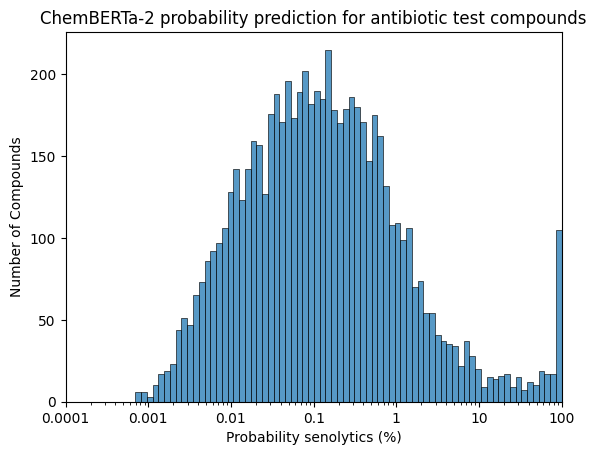

In [42]:
from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["prediction probability chemberta-2"],
    log_scale=True, binwidth=0.07)

plt.title("ChemBERTa-2 probability prediction for antibiotic test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.0001', '0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()

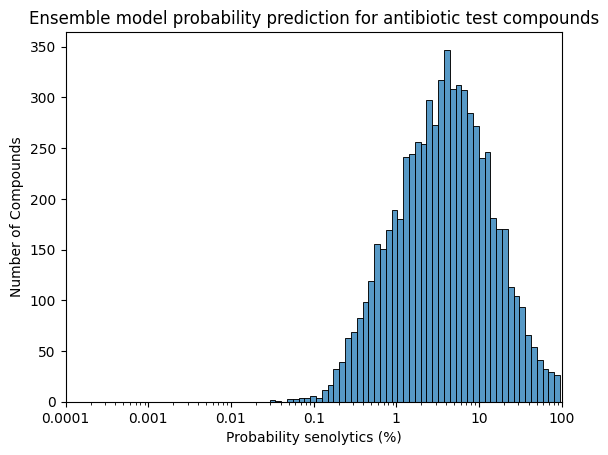

In [46]:
from matplotlib.ticker import ScalarFormatter
sns.histplot(data=test_df, x=100*test_df["Predicted probability"],
    log_scale=True, binwidth=0.07)

plt.title("Ensemble model probability prediction for antibiotic test compounds")
plt.ylabel('Number of Compounds')
plt.xlabel('Probability senolytics (%)')
#plt.xscale('log')
#plt.xticks([0.001, 0.01, 0.1, 1, 100])  # Set label locations.)
plt.xlim([0.001, 100])
# Define the desired tick positions and labels
tick_positions = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
tick_labels = ['0.0001', '0.001', '0.01', '0.1', '1', '10', '100']

# Set the tick positions and labels on the x-axis
plt.xticks(tick_positions, tick_labels)
plt.show()

## Wetlab results

In [49]:
wetlab_df = pd.read_excel('Dataset_antibiotic_superbug.xlsx', skiprows=1, sheet_name='Wetlab validation')
wetlab_df = wetlab_df[['SMILES','Sample','Rep_1','Rep_2','Mean_Growth','Grouth Truth label']] # get rid of column where says cut off = 0.2
wetlab_df

,SMILES,Sample,Rep_1,Rep_2,Mean_Growth,Grouth Truth label
0,Cc1cc(ccc1OCCOCC[N+](C)(C)Cc1ccccc1)C(C)(C)CC(...,BRD-K46531780-003-19-7,0.074926,0.079747,0.077337,1
1,CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,BRD-K34234316-003-05-4,0.081916,0.084844,0.083380,1
2,CCCCCCCCc1ccc(CCC(N)(CO)CO)cc1,BRD-K88025533-001-07-9,0.077447,0.093122,0.085284,1
3,Nc1nc(c(F)cc1F)-n1cc(C(O)=O)c(=O)c2cc(F)c(N3CC...,BRD-K90991629-100-02-9,0.084984,0.087582,0.086283,1
4,C[C@H]1NCc2cc(ccc12)-c1ccc2c(c1OC(F)F)n(cc(C(O...,BRD-K77038618-356-01-3,0.078571,0.095010,0.086791,1
...,...,...,...,...,...,...
235,Clc1c2C(=O)CC(=O)c2c(Cl)c(Cl)c1Cl,BRD-K27536248-001-03-9,1.073403,1.209607,1.141505,0
236,[H][C@]1(C)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(...,BRD-K00003135-001-01-9,1.077937,1.208391,1.143164,0
237,[O-][N+](=O)c1ccc(Cl)c(c1)[N+]([O-])=O,BRD-K97833335-001-08-2,1.134000,1.228834,1.181417,0
238,CCCCCCCCCCCCCCCCCCN(CCCCCCCCCCCCCCCCCC)CCCN(CC...,BRD-K26665484-001-01-8,1.225037,1.188530,1.206783,0


In [52]:
# Test samples in wetlab
test_df_predictions_in_wetlab = test_df_predictions[test_df_predictions['Sample'].isin(wetlab_df['Sample'])]

In [53]:
test_df_predictions_in_wetlab 

,Sample,SMILES,Predicted probability,prediction probability chemberta-2
4,BRD-K00494077-066-03-9,N[C@H]1[C@@H]2CN(C[C@H]12)c1nc2n(cc(C(O)=O)c(=...,0.924966,0.965941
6,BRD-K45916615-066-04-9,CN1C[C@@H]2C[C@H]1CN2c1cc2n(cc(C(O)=O)c(=O)c2c...,0.918660,0.997633
10,BRD-K01825499-003-03-9,N[C@H]1CCN(C1)c1c(F)cc2c(c1Cl)n(cc(C(O)=O)c2=O...,0.898453,0.976930
11,BRD-K90991629-100-02-9,Nc1nc(c(F)cc1F)-n1cc(C(O)=O)c(=O)c2cc(F)c(N3CC...,0.889775,0.992729
14,BRD-A47790386-001-05-9,CN[C@H]1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2...,0.885402,0.985812
...,...,...,...,...
304,BRD-K44849676-001-12-9,Oc1cc2CCCN(Cc2cc1O)C(=S)NCCc1ccc(Cl)cc1,0.326870,0.001619
305,BRD-K61642990-001-03-9,O\N=C\c1ccc(c(Cl)c1O)-c1ccc(O)c(F)c1,0.326751,0.000721
307,BRD-A61392169-001-03-9,O[C@@H](CN1CCC(Cc2ccc(F)cc2)CC1)c1ccc(Cl)cc1 |...,0.326161,0.004913
308,BRD-A85261566-001-03-3,CCOc1ccc(C[C@H]2NC(=O)CCSSC[C@H](NC(=O)[C@H](C...,0.326043,0.170340


In [55]:
wetlab_predictions = wetlab_df.merge(test_df_predictions_in_wetlab[['Sample','Predicted probability','prediction probability chemberta-2']], on='Sample')

In [56]:
wetlab_predictions

,SMILES,Sample,Rep_1,Rep_2,Mean_Growth,Grouth Truth label,Predicted probability,prediction probability chemberta-2
0,Cc1cc(ccc1OCCOCC[N+](C)(C)Cc1ccccc1)C(C)(C)CC(...,BRD-K46531780-003-19-7,0.074926,0.079747,0.077337,1,0.455561,0.005865
1,CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1,BRD-K34234316-003-05-4,0.081916,0.084844,0.083380,1,0.451942,0.013165
2,CCCCCCCCc1ccc(CCC(N)(CO)CO)cc1,BRD-K88025533-001-07-9,0.077447,0.093122,0.085284,1,0.374908,0.000747
3,Nc1nc(c(F)cc1F)-n1cc(C(O)=O)c(=O)c2cc(F)c(N3CC...,BRD-K90991629-100-02-9,0.084984,0.087582,0.086283,1,0.889775,0.992729
4,C[C@H]1NCc2cc(ccc12)-c1ccc2c(c1OC(F)F)n(cc(C(O...,BRD-K77038618-356-01-3,0.078571,0.095010,0.086791,1,0.508509,0.915147
...,...,...,...,...,...,...,...,...
235,Clc1c2C(=O)CC(=O)c2c(Cl)c(Cl)c1Cl,BRD-K27536248-001-03-9,1.073403,1.209607,1.141505,0,0.370996,0.002964
236,[H][C@]1(C)NC(=O)[C@H](C)NC(=O)[C@H](CC(C)C)N(...,BRD-K00003135-001-01-9,1.077937,1.208391,1.143164,0,0.360263,0.141203
237,[O-][N+](=O)c1ccc(Cl)c(c1)[N+]([O-])=O,BRD-K97833335-001-08-2,1.134000,1.228834,1.181417,0,0.563468,0.028620
238,CCCCCCCCCCCCCCCCCCN(CCCCCCCCCCCCCCCCCC)CCCN(CC...,BRD-K26665484-001-01-8,1.225037,1.188530,1.206783,0,0.476894,0.000150


In [57]:
wetlab_predictions.to_csv('chemberta2_wetlab_predictions.csv', index=True)